In [1]:
from librosa import load
from pathlib import Path
import numpy as np
import webrtcvad
import os 
import time
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

In [38]:
audio_path= Path('/home/zakaria/Desktop/Project/records/L_records_0.0_overlap')#/Nexus_ntlab_asn_ID_0.wav')
full  =  audio_path/'Pixel6b_ntlab_asn_ID_0.wav'#'Nexus_ntlab_asn_ID_0.wav'#'Pixel6b_ntlab_asn_ID_0.wav' Raspi_ntlab_asnupb2_ID_0 #Raspi_ntlab_asnupb4_ID_1


### load and generate chunks 

In [39]:
def load_audio(file_path, sr = None)-> np.ndarray:
    sig1 , sr = load(str(file_path), sr=sr, mono=True, duration=None)
    return sig1, sr

In [40]:
def chunk_generator(chunk_ms:int, audio_path:str):
    sig, sr = load_audio(audio_path)
    chunk_size = int((sr* chunk_ms)/1000) # calc the chunck size based on sr and duration
    
    start_idx = 0 

    while start_idx<len(sig):
        chunk = sig[start_idx:start_idx+chunk_size]
        yield chunk
        start_idx += chunk_size
        
    

### vad 

In [41]:
class ChunkVAD:

    def __init__(self):
        self.prev_energy = 0
        self.threshold = 0
        self.chunk_counter = 0
        self.sum_energy = 0
        self.random_counter = 0
        self.energy_vals =[]
        self.raw_energy_vals = []
        self.is_speech_vals = []
        self.raw_thresh = 0

    
    def process_chunk(self, chunk):
        ## if we are in the first second of the audio 
        ## calculate the average of the energy across the segments 
        if self.chunk_counter <= 32:
            self._energy(chunk)
            self.is_speech_vals.extend([0]*512)
            return 0
            
        elif self.threshold ==0:
            self.threshold = np.log(self.sum_energy/32)
            self.raw_thresh = (self.sum_energy/32)
        
        if self.prev_energy == 0:
            energy = np.sum(np.abs(chunk) ** 2)
        else:
            energy = 0.5 * self.prev_energy + 0.5 * np.sum(np.abs(chunk) ** 2)
            
        self.prev_energy = energy
        self.chunk_counter += 1
        en_log = np.log(energy)
        self.energy_vals.append(en_log)
        self.raw_energy_vals.append(energy)
        

        ## calculate the average of energy in the passt 1 sec 
        # recent_energy = self.raw_energy_vals[-1:]
        # recent_mean = np.mean(recent_energy)
        # recent_log = np.log(recent_mean)
        # self.threshold = 0.9* self.threshold + 0.1* recent_log


        print(f'time: {self.chunk_counter*32/1000} s   thresh: {self.raw_thresh} current_chunk: {self.prev_energy}')
        
        
        if (self.prev_energy)> (10*self.raw_thresh):
            self.is_speech_vals.extend([1]*512)    
            return 1
        else:
            self.is_speech_vals.extend([0]*512)
            recent_energy = self.raw_energy_vals[-2:]
            recent_mean = np.mean(recent_energy)
            self.raw_thresh = 0.8* self.raw_thresh + 0.2* recent_mean
            return 0


    def _energy(self,chunk):
        self.prev_energy = np.sum(np.abs(chunk)**2)
        self.sum_energy += self.prev_energy
        ## append the log value for plot 
        self.energy_vals.append(np.log(self.prev_energy))
        self.raw_energy_vals.append(self.prev_energy)
        self.chunk_counter +=1
        

    ## just for testing the energy values
    def calc_energy(self, chunk):
        energy = np.sum(np.abs(chunk)**2)
        self.random_counter += 1
        return self.random_counter, energy

    ## plot the energy  of all the chunks processed
    def plot_energy_across_chunks(self, chunk_size_ms=32):
        time_values = [i * chunk_size_ms / 1000 for i in range(len(self.energy_vals))]
        #print(f' len(time_values): {len(time_values)}')
        plt.figure(figsize=(16,6))
        plt.plot(time_values, self.energy_vals)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Energy')
        plt.title('Energy Across Chunks')
        plt.show()

    
    def plot_audio(self,signal, sr =16000):
        sig_size = len(signal)
        step_size = 1 / sr 
        duration = len(signal)/sr
        time_array = np.arange(0,duration, step_size)
        plt.figure(figsize=(16,6))
        # plot the audio signal
        plt.plot(time_array,signal, label ='Audio_signal', color='blue')
        # plot the voice_activation results
        plt.plot(time_array, self.is_speech_vals, label='is_speech_active', color='red') 
        plt.xlabel("time")
        plt.ylabel("Amplitude")
        plt.show()


            
            
        
        

### test Vad values

In [42]:
audio_data2 = chunk_generator(chunk_ms = 32, audio_path = full)
vad = ChunkVAD()

In [43]:

# each chunk is  32  ms  for a timestame  of 60 seconds  t = 1000*duration  / 32
for ex, idx in zip(audio_data2,range(1875)):  # for 60  seconds  range of (1875)
    is_speech = vad.process_chunk(ex)
    #print(f'time passed {vad.chunk_counter*32} ms, the threshold is {vad.threshold} is_speech: {is_speech}')
    #time.sleep(0.002)



time: 1.088 s   thresh: 0.0013700199779123068 current_chunk: 0.11934259859845042
time: 1.12 s   thresh: 0.0013700199779123068 current_chunk: 0.546795712551102
time: 1.152 s   thresh: 0.0013700199779123068 current_chunk: 0.8235909276409075
time: 1.184 s   thresh: 0.0013700199779123068 current_chunk: 0.930600848456379
time: 1.216 s   thresh: 0.0013700199779123068 current_chunk: 0.9912485910754185
time: 1.248 s   thresh: 0.0013700199779123068 current_chunk: 0.9751078999688616
time: 1.28 s   thresh: 0.0013700199779123068 current_chunk: 1.014507051142573
time: 1.312 s   thresh: 0.0013700199779123068 current_chunk: 1.2618969658178685
time: 1.344 s   thresh: 0.0013700199779123068 current_chunk: 1.3722547878405749
time: 1.376 s   thresh: 0.0013700199779123068 current_chunk: 0.8023342186997979
time: 1.408 s   thresh: 0.0013700199779123068 current_chunk: 0.5003885698711201
time: 1.44 s   thresh: 0.0013700199779123068 current_chunk: 0.34491334470089896
time: 1.472 s   thresh: 0.001370019977912306

In [44]:
vad.threshold

-6.592929956830684

60000.0


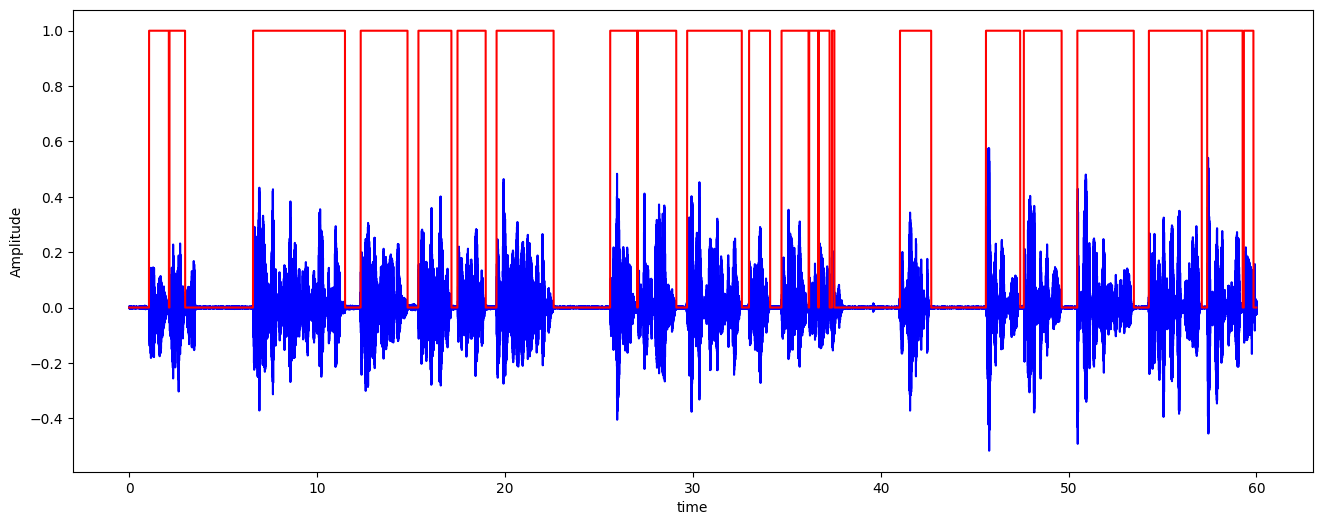

In [45]:
### audio for 60 seconds 
time_audio =  (len(vad.is_speech_vals)/16000) *1000  #  num of samples / samples per second * convert to ms
print(time_audio)
t_audio = chunk_generator(chunk_ms=time_audio, audio_path= full)
var = next(t_audio)
vad.plot_audio(var)

### plot energy chunks

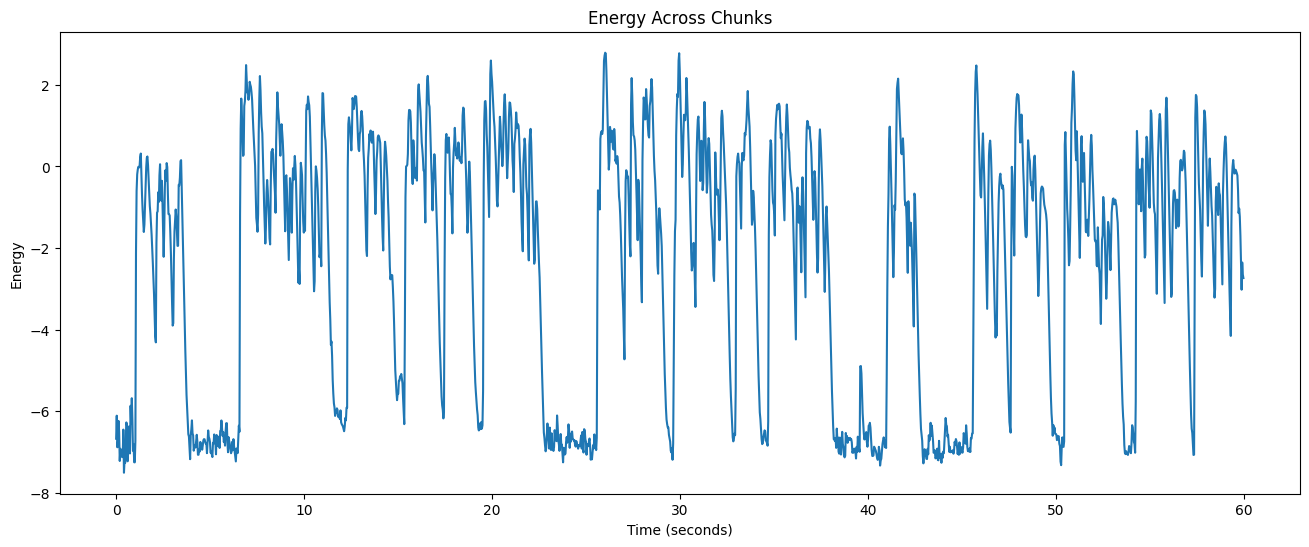

In [46]:
vad.plot_energy_across_chunks()

### plot spectrogram

In [ ]:
def plot_spectrogram(chunks, sampling_rate=16000, chunk_size=512, overlap=256):
        f, t, Sxx = spectrogram(chunks, fs=sampling_rate, nperseg=chunk_size, noverlap=overlap)
        plt.figure(figsize=(16,6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap='viridis')
        plt.colorbar(label='Power/Frequency (dB/Hz)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Spectrogram of Speech Signal')
        plt.show()
      

In [ ]:
audio_spectrogram = chunk_generator(chunk_ms=1000*60 ,audio_path =full)
audio_spe = next(audio_spectrogram)
plot_spectrogram(audio_spe)

### test energy vals 

In [ ]:
audio_data1 = chunk_generator(chunk_ms = 32, audio_path = full)

In [ ]:
## see energy vals :
VaD = ChunkVAD()
vad_lis = []
sum_energy = 0
for ex, idx in zip(audio_data1,range(50)):
    chunk_counter, energy  = VaD.calc_energy(ex)
    sum_energy += energy
    #print(f'time passed: {chunk_counter*32} ms energy for the current chunk: {np.log(energy)}')

#     if chunk_counter >=32:
#         print(f'the average log energy is {sum_energy}')
        
# print(np.log(sum_energy/32))

### using the vad function from webrtcvad

In [ ]:
vad = webrtcvad.Vad(3)  #doesn t work  yet

In [ ]:

# for ex,idx in zip(audio_data, range(5000)): # for five chuncks 
#     #  i get the chunck 
#     var = np.int16(ex * 32767)
#     ex_bytes = var.tobytes()
#     print(ex_bytes[:3])
#     is_speech = vad.is_speech(ex_bytes,16000)
#     time.sleep(0.002)
#     if is_speech:
#         print(is_speech)
#         print(idx)


  
    
    
    

    